# Week_10_Point_Clouds
Time capacity 3 $\pm$ 0.5 hours

by "First name" "Second name"

"Month, Day, 2025"

## Problem Statement

Implement a contrastive learning model using PyTorch Geometric to learn meaningful 
representations of 3D point clouds from the ModelNet10 dataset. The model should create 
embeddings where similar shapes are closer in the latent space.
Please chek the [original code](https://colab.research.google.com/drive/1oO-Raqge8oGXGNkZQOYTH-je4Xi1SFVI?usp=sharing#scrollTo=J49zjaa5cxRe) and [video](https://youtu.be/XpUKZEGWqbU?si=CpcJurPdDYG0kEGG).

MAIN TASK (2 points max):
- Improve baseline loss by:
  
  • Increasing the number of epochs (try 30-50)  
  • Balancing classes (limit samples per class)  
  • Changing the number of points (now the number of points is set to 512, it can be less or more)  
  • Adjusting temperature parameter
  • Using other options
 

BONUS TRACK (2 points max):
- Implement a classifier by (use one option, please note that the classes are imballanced):
  
  • Feature Extraction: Freeze contrastive model + train MLP classifier
  
  • Combined a Contrastive and a Classification Loss, please check [pytorch metric learning](https://github.com/KevinMusgrave/pytorch-metric-learning/tree/master)
  
  • Pure Classification: Train only classification head

Install Dependencies

In [1]:
import torch
# !pip install -q torch-cluster -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q pytorch-lightning pytorch-metric-learning plotly clearml

Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 37.9 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 41.9 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 9.6 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-v6mk7qmm
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-v6mk7qmm
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 6d668639c53eace9049e1bc1a7cc8877834f0d25
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.7.0-py3-none-any.whl size=118

In [2]:
import pytorch_lightning as pl
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader
# from torch_geometric.data import DataLoader
from torch_geometric.datasets import ModelNet
from torch_geometric.nn import MLP, DynamicEdgeConv, global_max_pool
from torch_geometric.transforms import SamplePoints, RandomJitter, RandomFlip, Compose
from pytorch_metric_learning.losses import NTXentLoss
import plotly.graph_objects as go
from pathlib import Path
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from clearml import Task
import os.path as osp

To configure ClearML in your Colab environment, follow these steps:

---

*Step 1: Create a ClearML Account*
1. Go to the [ClearML website](https://clear.ml/).
2. Sign up for a free account if you don’t already have one.
3. Once registered, log in to your ClearML account.

---

*Step 2: Get Your ClearML Credentials*
1. After logging in, navigate to the **Settings** page (click on your profile icon in the top-right corner and select **Settings**).
2. Under the **Workspace** section, find your **+ Create new credentials**.
3. Copy these credentials for a Jupiter notebook into the code cell below.

---

*Step 3: Accessing the ClearML Dashboard*
1. Go to your ClearML dashboard (https://app.clear.ml).
2. Navigate to the **Projects** section to see your experiments.
3. Click on the experiment (e.g., `Lab_1`) to view detailed metrics, logs, and artifacts.

---

In [3]:
#Enter your code here to implement Step 2 of the logging instruction as it is shown below
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=ZP02U03C6V5ER4K9VWRNZT7EWA5ZTV
%env CLEARML_API_SECRET_KEY=BtA5GXZufr6QGpaqhX1GSKPTvaCt56OLqaNqUGLNoxx2Ye8Ctwbui0Ln5OXVnzUgH4I

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=ZP02U03C6V5ER4K9VWRNZT7EWA5ZTV
env: CLEARML_API_SECRET_KEY=BtA5GXZufr6QGpaqhX1GSKPTvaCt56OLqaNqUGLNoxx2Ye8Ctwbui0Ln5OXVnzUgH4I


Initialization

In [4]:
params = {
        'lr': 1e-3,
        'temperature': 0.1,
        'batch_size': 32,
        'max_epochs': 5,
}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Dataset Setup

In [5]:
class ModelNet10DataModule(pl.LightningDataModule):
    CLASS_NAMES = [
        'bathtub', 'bed', 'chair', 'desk', 'dresser',
        'monitor', 'night_stand', 'sofa', 'table', 'toilet'
    ]
    
    def __init__(self, batch_size=32, num_points=512):
        super().__init__()
        self.batch_size = batch_size
        self.num_points = num_points
        self.base_transform = SamplePoints(num_points)
        self.augmentation = Compose([
            RandomJitter(0.03),
            RandomFlip(1)
        ])

    def prepare_data(self):
        # Download datasets
        ModelNet(root='./ModelNet10', name='10', train=True)
        ModelNet(root='./ModelNet10', name='10', train=False)

    def setup(self, stage=None):
        self.train_dataset = ModelNet(
            root='./ModelNet10',
            name='10',
            train=True,
            transform=self.base_transform
        )
        self.val_dataset = ModelNet(
            root='./ModelNet10',
            name='10',
            train=False,
            transform=self.base_transform
        )
        
        print(f"Training classes: {self.CLASS_NAMES}")
        print(f"Training samples: {len(self.train_dataset)}")
        print(f"Validation samples: {len(self.val_dataset)}")

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=2
        )

Model Definition

In [6]:
class PointCloudContrastive(pl.LightningModule):
    def __init__(self, params=params, lr=params["lr"], temperature=params["temperature"]):
        super().__init__()
        self.save_hyperparameters()
        self.batch_size = params["batch_size"]
        
        # Architecture components
        self.conv1 = DynamicEdgeConv(MLP([2*3, 64, 64]), k=20, aggr='max')
        self.conv2 = DynamicEdgeConv(MLP([2*64, 128]), k=20, aggr='max')
        self.projection_head = MLP([128+64, 256, 128], norm=None)
        
        # Loss function
        self.criterion = NTXentLoss(temperature=temperature)

    def forward(self, data):
        pos = data.pos.to(self.device)
        batch = data.batch.to(self.device)
        
        x1 = self.conv1(pos, batch)
        x2 = self.conv2(x1, batch)
        h_points = self.projection_head(torch.cat([x1, x2], dim=1))
        return global_max_pool(h_points, batch)

    def training_step(self, batch, batch_idx):
        aug1, aug2 = self._generate_augmented_views(batch)
        z1, z2 = self(aug1), self(aug2)
        loss = self._compute_contrastive_loss(z1, z2)
        
        self.log('train_loss', loss, 
                 batch_size=self.batch_size, 
                 prog_bar=True, on_step=True, on_epoch=True)
        self.log('learning_rate', self.optimizers().param_groups[0]['lr'], 
                on_step=True, on_epoch=False)
        return loss

    def validation_step(self, batch, batch_idx):
        aug1, aug2 = self._generate_augmented_views(batch)
        z1, z2 = self(aug1), self(aug2)
        loss = self._compute_contrastive_loss(z1, z2)
        self.log('val_loss', loss, 
                 batch_size=self.batch_size, 
                 prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def _generate_augmented_views(self, batch):
        aug1 = batch.clone()
        aug1.pos = torch.cat([self.trainer.datamodule.augmentation(d).pos 
                            for d in batch.to_data_list()])
        aug2 = batch.clone()
        aug2.pos = torch.cat([self.trainer.datamodule.augmentation(d).pos 
                            for d in batch.to_data_list()])
        return aug1, aug2

    def _compute_contrastive_loss(self, z1, z2):
        labels = torch.arange(z1.size(0), device=self.device)
        return self.criterion(torch.cat([z1, z2]), torch.cat([labels, labels]))

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)
        return [optimizer], [scheduler]

    def configure_callbacks(self):
        return [
            pl.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                mode='min',
                check_on_train_epoch_end=False
            )
        ]

Visualization

In [7]:
def plot_sample(data, title=""):
    pos = data.pos.cpu().numpy()
    label_idx = data.y.item() if hasattr(data, 'y') else 0
    class_name = ModelNet10DataModule.CLASS_NAMES[label_idx]
    
    fig = go.Figure(data=[go.Scatter3d(
        x=pos[:,0], y=pos[:,1], z=pos[:,2],
        mode='markers',
        marker=dict(size=3, opacity=0.8, color=pos[:,2], colorscale='Viridis')
    )])
    fig.update_layout(
        title=f"{class_name}: {title}",
        scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
        width=800,
        height=600
    )
    fig.show()

def check_class_distribution(dataset):
    class_counts = {name: 0 for name in ModelNet10DataModule.CLASS_NAMES}
    for data in dataset:
        class_counts[ModelNet10DataModule.CLASS_NAMES[data.y]] += 1
    print("Class distribution:")
    for cls, count in class_counts.items():
        print(f"{cls}: {count} samples")

def visualize_augmentations(dm):
    # Get original samples from different classes
    sample_indices = [
        next(i for i, d in enumerate(dm.train_dataset) if d.y == class_idx)
        for class_idx in range(5)  # First 5 classes
    ]
    
    for idx in sample_indices:
        original = dm.train_dataset[idx]
        plot_sample(original, "Original")
        
        # Create augmented version
        augmented = original.clone()
        augmented.pos = dm.augmentation(augmented).pos
        plot_sample(augmented, "Augmented")
        
def visualize_embeddings(model, datamodule, device, title=""):
    model.eval()
    with torch.no_grad():
        # Get sample batch and move to device
        loader = datamodule.train_dataloader()
        sample = next(iter(loader))
        sample = sample.to(device)  # Move entire batch to device
        
        # Get representations
        h = model(sample)
        h = h.cpu().numpy()
        labels = [datamodule.CLASS_NAMES[y] for y in sample.y.cpu().numpy()]

        # t-SNE dimensionality reduction
        tsne = TSNE(n_components=2, perplexity=15, random_state=42)
        h_embedded = tsne.fit_transform(h)

        # Plot
        plt.figure(figsize=(10, 8))
        sns.scatterplot(x=h_embedded[:,0], y=h_embedded[:,1], 
                        hue=labels, palette="tab10", alpha=0.7)
        plt.title(f"t-SNE Embeddings {title}")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

In [8]:
# Check PyG version
import torch_geometric
print(torch_geometric.__version__)  # Should be ≥ 2.4.0
# If version ≥ 2.4.0, you can safely use RandomShear

2.7.0


Training

ClearML Task: created new task id=158330f1c05c48e382ea9eb29a50c136
2025-03-29 12:48:08,117 - clearml.Repository Detection - WARNING - Failed accessing the jupyter server(s): []
2025-03-29 12:48:08,126 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.clear.ml/projects/25116739d9cb4770af147ec183f42c81/experiments/158330f1c05c48e382ea9eb29a50c136/output/log


Extracting ModelNet10/ModelNet10.zip
Processing...


ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


Done!


Training classes: ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']
Training samples: 3991
Validation samples: 908


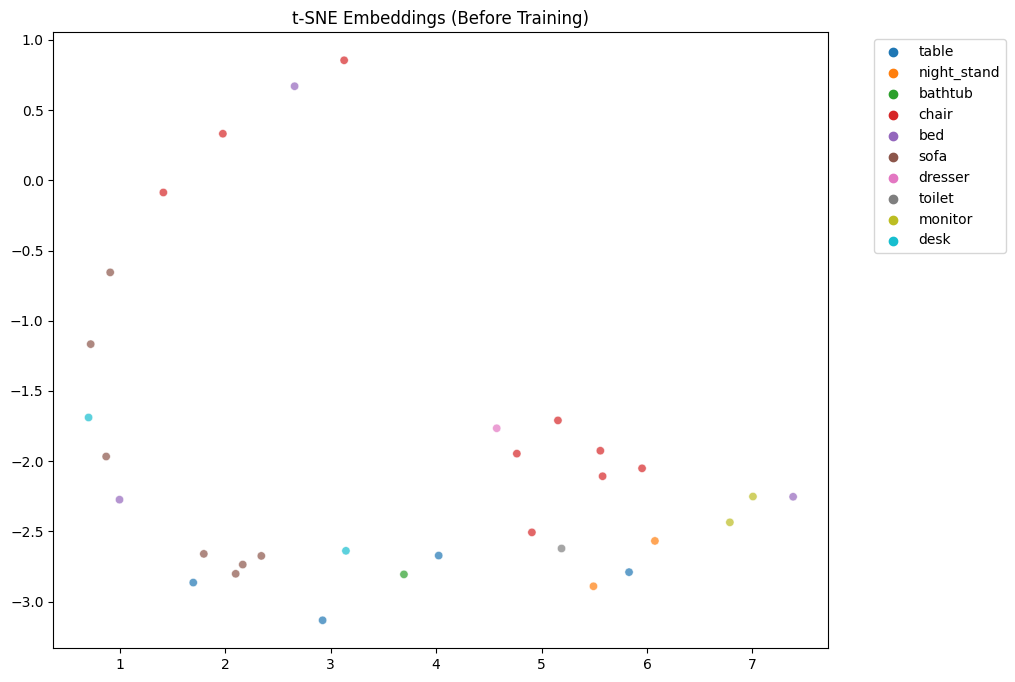

Training classes: ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']
Training samples: 3991
Validation samples: 908


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/tensorboard.py:195: UserWarning:

Could not log computational graph to TensorBoard: The `model.example_input_array` attribute is not set or `input_array` was not given.



Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [9]:
if __name__ == "__main__":
    # Initialize ClearML Task with proper framework connection
    task = Task.init(
        project_name="PointCloudContrastiveLearning",
        task_name="ContrastiveModel_Training",
        auto_connect_frameworks={'pytorch': False, 
                                 'tensorflow': False, 'tensorboard': True}
    )
    task.connect(params)
    
    # Initialize components
    dm = ModelNet10DataModule(batch_size=params['batch_size'])
    model = PointCloudContrastive(lr=params['lr'], temperature=params['temperature'])

    logger = pl.loggers.TensorBoardLogger(
        save_dir="logs",
        name="contrastive_model",
        log_graph=True
    )
    # Configure trainer
    trainer = pl.Trainer(
        max_epochs=params['max_epochs'],
        accelerator='auto',
        devices=1,
        logger=logger,
        log_every_n_steps=10,
        callbacks=model.configure_callbacks(),
    )
    
    # Start training
    dm.setup()
    model.to(device)
    visualize_embeddings(model, dm, device, "(Before Training)")
    
    trainer.fit(model, dm)
    
    # Save and log final model
    torch.save(model.state_dict(), 'contrastive_model.pt')
    task.upload_artifact('model_weights', 'contrastive_model.pt')
    task.close()


After training:


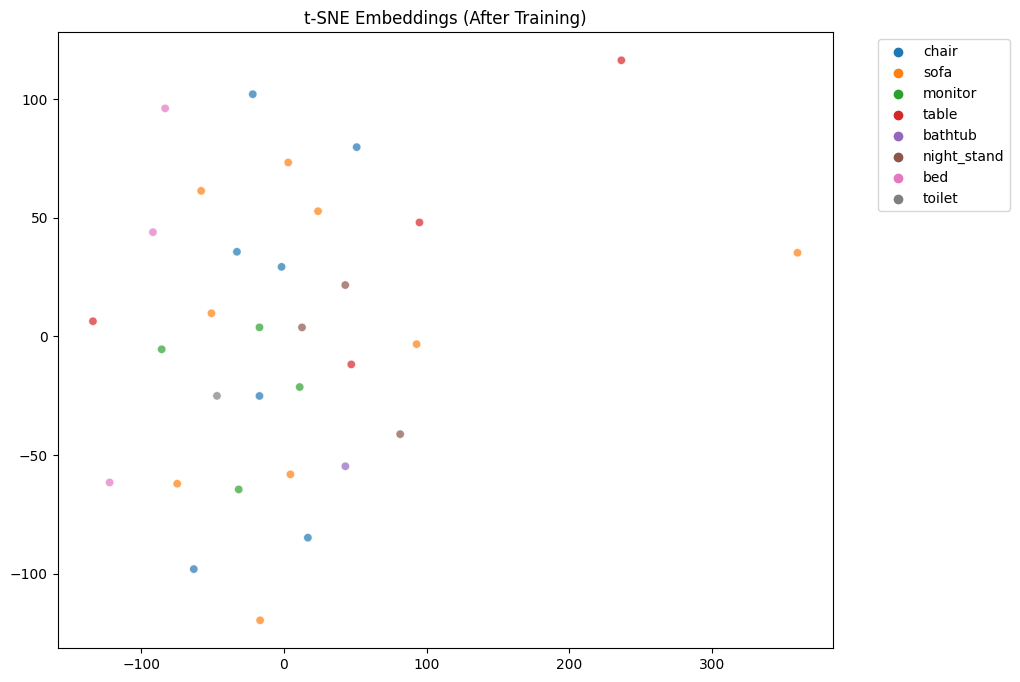

In [10]:
# Post-training visualization
print("\nAfter training:")
visualize_embeddings(model, dm, device, "(After Training)")
    
# Save model
torch.save(model.state_dict(), 'contrastive_model.pt')

In [11]:
# Should better output balanced classes
check_class_distribution(dm.train_dataset)

Class distribution:
bathtub: 106 samples
bed: 515 samples
chair: 889 samples
desk: 200 samples
dresser: 200 samples
monitor: 465 samples
night_stand: 200 samples
sofa: 680 samples
table: 392 samples
toilet: 344 samples


In [12]:
# Shows matching class labels for original/augmented pairs
visualize_augmentations(dm)

Training classes: ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']
Training samples: 3991
Validation samples: 908


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/tensorboard.py:195: UserWarning:

Could not log computational graph to TensorBoard: The `model.example_input_array` attribute is not set or `input_array` was not given.



Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.17408475279808044    │
└───────────────────────────┴───────────────────────────┘


Final Validation Loss: 0.1741


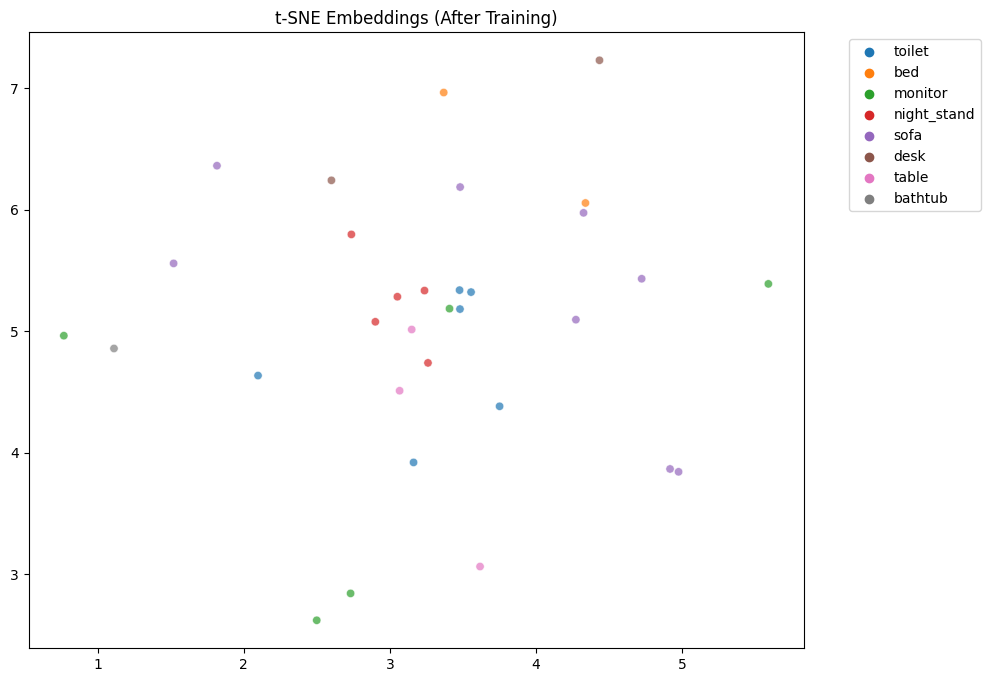

In [13]:
    # Properly indented validation report
    val_results = trainer.validate(model, dm.val_dataloader())
    print(f"\nFinal Validation Loss: {val_results[0]['val_loss']:.4f}")
    
    visualize_embeddings(model, dm, device, "(After Training)")
    torch.save(model.state_dict(), 'contrastive_model.pt')